In [1]:
import os
import pandas as pd

## Reading dataset

In [2]:
path = "archive/20news-19997/20_newsgroups"
df = []

for folder in os.listdir(path):
    for file in os.listdir(f'{path}/{folder}'):
        f = open(f'{path}/{folder}/{file}', 'rb')
        df.append({'text': f.read(), 'newsgroup': folder})

In [3]:
df = pd.DataFrame(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       19997 non-null  object
 1   newsgroup  19997 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [4]:
df.head()

text    newsgroup
0  b'Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:...  alt.atheism
1  b'Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:...  alt.atheism
2  b'Newsgroups: alt.atheism\nPath: cantaloupe.sr...  alt.atheism
3  b'Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:...  alt.atheism
4  b'Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:...  alt.atheism

In [5]:
df["text"][0]

b'Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49960 alt.atheism.moderated:713 news.answers:7054 alt.answers:126\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!magnus.acs.ohio-state.edu!usenet.ins.cwru.edu!agate!spool.mu.edu!uunet!pipex!ibmpcug!mantis!mathew\nFrom: mathew <mathew@mantis.co.uk>\nNewsgroups: alt.atheism,alt.atheism.moderated,news.answers,alt.answers\nSubject: Alt.Atheism FAQ: Atheist Resources\nSummary: Books, addresses, music -- anything related to atheism\nKeywords: FAQ, atheism, books, music, fiction, addresses, contacts\nMessage-ID: <19930329115719@mantis.co.uk>\nDate: Mon, 29 Mar 1993 11:57:19 GMT\nExpires: Thu, 29 Apr 1993 11:57:19 GMT\nFollowup-To: alt.atheism\nDistribution: world\nOrganization: Mantis Consultants, Cambridge. UK.\nApproved: news-answers-request@mit.edu\nSupersedes: <19930301143317@mantis.co.uk>\nLines: 290\n\nArchive-name: atheism/resources\nAlt-atheism-archive-name: resources\nLast-

## Converting bytes to string

In [6]:
def bytes_to_str(text):
    return text.decode('utf-8', errors = 'ignore')
df["text"]=df["text"].apply(bytes_to_str)

In [7]:
df

text           newsgroup
0      Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49...         alt.atheism
1      Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...         alt.atheism
2      Newsgroups: alt.atheism\nPath: cantaloupe.srv....         alt.atheism
3      Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...         alt.atheism
4      Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...         alt.atheism
...                                                  ...                 ...
19992  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:54...  talk.religion.misc
19993  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:54...  talk.religion.misc
19994  Xref: cantaloupe.srv.cs.cmu.edu talk.religion....  talk.religion.misc
19995  Xref: cantaloupe.srv.cs.cmu.edu talk.religion....  talk.religion.misc
19996  Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...  talk.religion.misc

[19997 rows x 2 columns]

In [8]:
df["newsgroup"].nunique()

20

## Removing headers

In [9]:
def remove_header(text):
    split_text = text.split('\n\n', 1)
    if len(split_text) > 1:
        return split_text[1]
    return text
df["text"] = df["text"].apply(remove_header)

## Dividing into build and valid datasets

In [10]:
from sklearn.model_selection import train_test_split

print(df.shape)

X_build, X_val = train_test_split(
    df,
    test_size=0.3, random_state=213)

print("X_build shape: {}".format(X_build.shape))
print("X_val shape: {}".format(X_val.shape))

(19997, 2)
X_build shape: (13997, 2)
X_val shape: (6000, 2)


In [11]:
df = X_build.copy()
original_df = df.copy()

### Counting sentences

In [12]:
from nltk.tokenize import sent_tokenize
df["sentences"]=df["text"].apply(sent_tokenize).apply(len)

### Counting question and exclamation marks

In [13]:
df["question_marks_ratio"] = df["text"].str.count("\?")/df["sentences"]
df["exclamation_marks_ratio"] = df["text"].str.count("\!")/df["sentences"]

### Counting links

In [14]:
df["links"] = df["text"].str.count(r'https?://\S+|www\.\S+')

### Counting e-mail addresses

In [15]:
df["emails_addresses"] = df["text"].str.count(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')

## Cleaning

In [16]:
import string
import re

def clean(df):
    df["text"] = df['text'].str.replace('https?://\S+|www\.\S+', '', regex = True) # links
    df["text"] = df["text"].str.replace(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', '', regex = True) # e-mail adresses
    df["text"] = df['text'].str.replace('<.*?>+', '', regex = True) # tags
    df["text"] = df['text'].str.replace('\[.*?\]', '', regex = True) # square brackets
    df["text"] = df['text'].str.replace('[%s]' % re.escape(string.punctuation), '', regex = True) # puntuation marks
    df["text"] = df['text'].str.replace('\n', ' ', regex = True) # newline character
    df["text"] = df['text'].str.replace("\\W"," ", regex = True) # non-alphanumeric characters
    df["text"] = df['text'].str.replace('\w*\d\w*', '', regex = True) # numeric sequences
    df["text"] = df['text'].str.replace(r'\b\w\b', '', regex = True) # one-letter words
    df["text"] = df['text'].str.replace(r'\s+', ' ', regex = True) # empty spaces
    return df

df = clean(df)
df.head()

text  \
12727   In article pethybridge writes Hello again ask...   
12958  In scielectronics Geoff Swan writes Rubbish Th...   
17116   In article craig brown writes In article Moha...   
6186   GRE Test Aids for Sale Cliffs GRE Preparation ...   
6782    For SIZE wedding dress with lots of beads inq...   

                   newsgroup  sentences  question_marks_ratio  \
12727        sci.electronics          4              0.000000   
12958        sci.electronics         17              0.117647   
17116  talk.politics.mideast         25              0.040000   
6186            misc.forsale         18              0.000000   
6782            misc.forsale          2              0.000000   

       exclamation_marks_ratio  links  emails_addresses  
12727                 0.000000      0                 2  
12958                 0.000000      0                 4  
17116                 0.280000      0                 4  
6186                  0.333333      0                 1  
6782                  0.000000      0                 0

### Spacy

In [17]:
import spacy
import pandas as pd

def extract_named_entities(df):
    nlp = spacy.load("en_core_web_sm")

    entity_types = ['ORG', 'MONEY', 'PERSON', 'COMPANY', 'GPE', 'DATE']
    new_columns = ['{}_entities'.format(entity_type.lower()) for entity_type in entity_types]
    df[new_columns] = pd.DataFrame([[None] * len(new_columns)], index=df.index)

    for i, row in df.iterrows():
        text = row['text']

        doc = nlp(text)

        entities = {entity_type: [] for entity_type in entity_types}
        for ent in doc.ents:
            if ent.label_ in entities:
                entities[ent.label_].append(ent.text)

        for entity_type, values in entities.items():
            df.at[i, '{}_entities'.format(entity_type.lower())] = ', '.join(values)

    return df

In [18]:
df = extract_named_entities(df)

In [19]:
df

text  \
12727   In article pethybridge writes Hello again ask...   
12958  In scielectronics Geoff Swan writes Rubbish Th...   
17116   In article craig brown writes In article Moha...   
6186   GRE Test Aids for Sale Cliffs GRE Preparation ...   
6782    For SIZE wedding dress with lots of beads inq...   
...                                                  ...   
11051  Yes my error you will need the DIFF between th...   
17409  In article CASPERDAVIPPE writes Are you aware ...   
8032    When first started riding street bikes was to...   
13540   Hi we are just completing project on nebulise...   
19755  In article writes Actually both are positive a...   

                   newsgroup  sentences  question_marks_ratio  \
12727        sci.electronics          4              0.000000   
12958        sci.electronics         17              0.117647   
17116  talk.politics.mideast         25              0.040000   
6186            misc.forsale         18              0.000000   
6782            misc.forsale          2              0.000000   
...                      ...        ...                   ...   
11051              sci.crypt          4              0.250000   
17409  talk.politics.mideast         13              0.230769   
8032         rec.motorcycles          8              0.000000   
13540                sci.med          6              0.166667   
19755     talk.religion.misc         22              0.045455   

       exclamation_marks_ratio  links  emails_addresses  \
12727                 0.000000      0                 2   
12958                 0.000000      0                 4   
17116                 0.280000      0                 4   
6186                  0.333333      0                 1   
6782                  0.000000      0                 0   
...                        ...    ...               ...   
11051                 0.000000      0                 1   
17409                 0.153846      0                 3   
8032                  0.250000      0                 1   
13540                 0.000000      0                 1   
19755                 0.000000      0                 2   

                                            org_entities  \
12727                                                      
12958  QST, SSBCW, CWSSBFM US Mail, QRP, Newington CT...   
17116  PBS, CBC Snoozeworld Almost, MW, IAEA, IAEA, I...   
6186   GRE Test, Cliffs Notes GRE Economics Test, the...   
6782                                                SIZE   
...                                                  ...   
11051           DIFF, MacPGP, Please, FTP, SED, AppMaker   
17409                              Ending, nonChristians   
8032                             HARLEY, Harley, Wizards   
13540                                                      
19755  Beethovens symphony backwards, FBI, Koreshs ar...   

                                 money_entities  \
12727                                             
12958                                             
17116  billions of dollars, billions of dollars   
6186                                              
6782                                              
...                                         ...   
11051                                             
17409                                             
8032                                              
13540                                             
19755                                             

                                         person_entities company_entities  \
12727                                      Steven Murray                    
12958  Geoff Swan, Zack Lau, Zack Lau, Slan, Risky Ge...                    
17116                      craig brown, Mohamad Ebrahimi                    
6186   Shipping, Keith Frederick Happiness, Fu Manchu...                    
6782                                                                        
...                                          

In [20]:
import pandas as pd

def calculate_word_vector_length(df, column_name):
    new_column_name = column_name + '_length'
    df[new_column_name] = df[column_name].apply(lambda x: len(x.replace(' ', ',').split(',')) if x.strip() else 0)
    return df


In [21]:
df = calculate_word_vector_length(df, 'org_entities')
df = calculate_word_vector_length(df, 'money_entities')
df = calculate_word_vector_length(df, 'person_entities')
df = calculate_word_vector_length(df, 'company_entities')
df = calculate_word_vector_length(df, 'gpe_entities')
df = calculate_word_vector_length(df, 'date_entities')
df

text  \
12727   In article pethybridge writes Hello again ask...   
12958  In scielectronics Geoff Swan writes Rubbish Th...   
17116   In article craig brown writes In article Moha...   
6186   GRE Test Aids for Sale Cliffs GRE Preparation ...   
6782    For SIZE wedding dress with lots of beads inq...   
...                                                  ...   
11051  Yes my error you will need the DIFF between th...   
17409  In article CASPERDAVIPPE writes Are you aware ...   
8032    When first started riding street bikes was to...   
13540   Hi we are just completing project on nebulise...   
19755  In article writes Actually both are positive a...   

                   newsgroup  sentences  question_marks_ratio  \
12727        sci.electronics          4              0.000000   
12958        sci.electronics         17              0.117647   
17116  talk.politics.mideast         25              0.040000   
6186            misc.forsale         18              0.000000   
6782            misc.forsale          2              0.000000   
...                      ...        ...                   ...   
11051              sci.crypt          4              0.250000   
17409  talk.politics.mideast         13              0.230769   
8032         rec.motorcycles          8              0.000000   
13540                sci.med          6              0.166667   
19755     talk.religion.misc         22              0.045455   

       exclamation_marks_ratio  links  emails_addresses  \
12727                 0.000000      0                 2   
12958                 0.000000      0                 4   
17116                 0.280000      0                 4   
6186                  0.333333      0                 1   
6782                  0.000000      0                 0   
...                        ...    ...               ...   
11051                 0.000000      0                 1   
17409                 0.153846      0                 3   
8032                  0.250000      0                 1   
13540                 0.000000      0                 1   
19755                 0.000000      0                 2   

                                            org_entities  \
12727                                                      
12958  QST, SSBCW, CWSSBFM US Mail, QRP, Newington CT...   
17116  PBS, CBC Snoozeworld Almost, MW, IAEA, IAEA, I...   
6186   GRE Test, Cliffs Notes GRE Economics Test, the...   
6782                                                SIZE   
...                                                  ...   
11051           DIFF, MacPGP, Please, FTP, SED, AppMaker   
17409                              Ending, nonChristians   
8032                             HARLEY, Harley, Wizards   
13540                                                      
19755  Beethovens symphony backwards, FBI, Koreshs ar...   

                                 money_entities  \
12727                                             
12958                                             
17116  billions of dollars, billions of dollars   
6186                                              
6782                                              
...                                         ...   
11051                                             
17409                                             
8032                                              
13540                                             
19755                                             

                                         person_entities company_entities  \
12727                                      Steven Murray                    
12958  Geoff Swan, Zack Lau, Zack Lau, Slan, Risky Ge...                    
17116                      craig brown, Mohamad Ebrahimi                    
6186   Shipping, Keith Frederick Happiness, Fu Manchu...                    
6782                                                                        
...                                          

In [22]:
df = df.drop(['org_entities', 'money_entities', 'person_entities', 'company_entities', 'gpe_entities', 'date_entities'], axis = 1)

## Converting to lowercase, counting ratio for entities

In [23]:
df["chars"]=df["text"].str.len()
df["capital_letters_ratio"] = df["text"].str.count(r'[A-Z]')/df["text"].str.count(r'[A-za-z]')
df["text"] = df['text'].str.lower()

In [24]:
df['organizations_ratio'] = df['org_entities_length']/df['chars']
df['money_ratio'] = df['money_entities_length']/df['chars']
df['person_ratio'] = df['person_entities_length']/df['chars']
df['company_ratio'] = df['company_entities_length']/ df['chars']
df['gpe_ratio'] = df['gpe_entities_length']/ df['chars']
df['date_ratio'] = df['date_entities_length']/df['chars']

In [25]:
df = df.drop(['org_entities_length','money_entities_length','person_entities_length','company_entities_length','gpe_entities_length','date_entities_length'], axis = 1)
df

text  \
12727   in article pethybridge writes hello again ask...   
12958  in scielectronics geoff swan writes rubbish th...   
17116   in article craig brown writes in article moha...   
6186   gre test aids for sale cliffs gre preparation ...   
6782    for size wedding dress with lots of beads inq...   
...                                                  ...   
11051  yes my error you will need the diff between th...   
17409  in article casperdavippe writes are you aware ...   
8032    when first started riding street bikes was to...   
13540   hi we are just completing project on nebulise...   
19755  in article writes actually both are positive a...   

                   newsgroup  sentences  question_marks_ratio  \
12727        sci.electronics          4              0.000000   
12958        sci.electronics         17              0.117647   
17116  talk.politics.mideast         25              0.040000   
6186            misc.forsale         18              0.000000   
6782            misc.forsale          2              0.000000   
...                      ...        ...                   ...   
11051              sci.crypt          4              0.250000   
17409  talk.politics.mideast         13              0.230769   
8032         rec.motorcycles          8              0.000000   
13540                sci.med          6              0.166667   
19755     talk.religion.misc         22              0.045455   

       exclamation_marks_ratio  links  emails_addresses  chars  \
12727                 0.000000      0                 2    412   
12958                 0.000000      0                 4   2285   
17116                 0.280000      0                 4   3761   
6186                  0.333333      0                 1    911   
6782                  0.000000      0                 0     75   
...                        ...    ...               ...    ...   
11051                 0.000000      0                 1    407   
17409                 0.153846      0                 3   1252   
8032                  0.250000      0                 1    498   
13540                 0.000000      0                 1    857   
19755                 0.000000      0                 2   1692   

       capital_letters_ratio  organizations_ratio  money_ratio  person_ratio  \
12727               0.054054             0.000000     0.000000      0.004854   
12958               0.074132             0.011816     0.000000      0.008315   
17116               0.031100             0.005584     0.001861      0.001329   
6186                0.109948             0.036224     0.000000      0.013172   
6782                0.150000             0.013333     0.000000      0.000000   
...                      ...                  ...          ...           ...   
11051               0.134328             0.027027     0.000000      0.004914   
17409               0.055233             0.002396     0.000000      0.001597   
8032                0.056931             0.010040     0.000000      0.010040   
13540               0.049793             0.000000     0.000000      0.007001   
19755               0.022727             0.006501     0.000000      0.001182   

       company_ratio  gpe_ratio  date_ratio  
12727            0.0   0.000000    0.007282  
12958            0.0   0.000000    0.001751  
17116            0.0   0.010635    0.004786  
6186             0.0   0.000000    0.001098  
6782             0.0   0.013333    0.000000  
...              ...        ...         ...  
11051            0.0   0.000000    0.000000  
17409            0.0   0.007188    0.008786  
8032             0.0   0.000000    0.000000  
13540            0.0   0.000000    0.002334  
19755            0.0   0.000591    0.002364  

[13997 rows x 15 columns]

## Removing stopwords

In [26]:
from nltk.corpus import stopwords

def remove_stopwords(text):
 stop = set(stopwords.words('english'))
 text = [word for word in text.split() if word not in stop]
 text = ' '.join(x for x in text)
 return text

df['text'] = df['text'].apply(remove_stopwords)

## Cleaning missing data

In [27]:
df = df[(df["text"] != '') & (df["text"] != '[]')]

In [28]:
df["text"] = df["text"].apply(str)

C:\Users\User\AppData\Local\Temp\ipykernel_10276\1434408237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df["text"].apply(str)


## POS tagging and lemmatization

In [29]:
from nltk.corpus import wordnet
import nltk
from nltk.stem import WordNetLemmatizer

def pos_tag_and_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    lemmas = []
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    token_count = len(tokens)
    unique_words = len(set(tokens))

    if token_count == 0:
        return lemmas, noun_count, adj_count, verb_count, adv_count, token_count, unique_words

    lemmatizer = WordNetLemmatizer()

    for token, pos in pos_tags:
        wn_pos = nltk.corpus.wordnet.NOUN
        if pos.startswith('J'):
            wn_pos = wordnet.ADJ
            adj_count += 1
        elif pos.startswith('V'):
            wn_pos = wordnet.VERB
            verb_count += 1
        elif pos.startswith('R'):
            wn_pos = wordnet.ADV
            adv_count += 1
        else:
            noun_count += 1

        lemma = lemmatizer.lemmatize(token, pos=wn_pos)
        lemmas.append(lemma)

    noun_ratio = noun_count/token_count
    adj_ratio = adj_count/token_count
    verb_ratio = verb_count/token_count
    adv_ratio = adv_count/token_count

    lemmas = " ".join(lemmas)

    return lemmas, noun_ratio, adj_ratio, verb_ratio, adv_ratio, token_count, unique_words

# Apply POS-tagging, lemmatization, and count to the DataFrame
df[['text', 'noun_ratio', 'adj_ratio', 'verb_ratio', 'adv_ratio', 'words', 'unique_words']] = df['text'].apply(pos_tag_and_lemmatize).apply(pd.Series)

C:\Users\User\AppData\Local\Temp\ipykernel_10276\4038826019.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['text', 'noun_ratio', 'adj_ratio', 'verb_ratio', 'adv_ratio', 'words', 'unique_words']] = df['text'].apply(pos_tag_and_lemmatize).apply(pd.Series)
C:\Users\User\AppData\Local\Temp\ipykernel_10276\4038826019.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['text', 'noun_ratio', 'adj_ratio', 'verb_ratio', 'adv_ratio', 'words', 'unique_words']] = df['text'].apply(pos_tag_and_lemmatize).a

## Grouping by similar words

In [30]:
import spacy
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

def group_records_by_similar_words(df):
    # Load spaCy model
    nlp = spacy.load("en_core_web_sm")

    # Tokenize and vectorize the text
    tokenized_text = []
    vectors = []
    for doc in nlp.pipe(df['text'], batch_size=1000):
        tokenized_text.append([token.text for token in doc])
        vectors.append(doc.vector)

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(vectors)

    # Apply K-means clustering
    k = int(len(df) ** 0.5)  # Determine the number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(similarity_matrix)

    # Add cluster labels to the DataFrame
    df['cluster'] = cluster_labels

    return df

## Lexical diversity

In [31]:
df['lexical_div'] = df['words'] / df['unique_words']

C:\Users\User\AppData\Local\Temp\ipykernel_10276\2291121900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lexical_div'] = df['words'] / df['unique_words']


## Average word length

In [32]:
df['avg_word_length'] = df['chars'] / df['words']

C:\Users\User\AppData\Local\Temp\ipykernel_10276\2185371058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_word_length'] = df['chars'] / df['words']


## Sentiment analysis

In [33]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

# Calculate the sentiment scores for all texts
sentiment_scores = df['text'].apply(lambda text: sia.polarity_scores(text))

# Extract negative, positive, and neutral scores into separate columns
df['negative'] = sentiment_scores.apply(lambda score: score['neg'])
df['positive'] = sentiment_scores.apply(lambda score: score['pos'])
df['neutral'] = sentiment_scores.apply(lambda score: score['neu'])

C:\Users\User\AppData\Local\Temp\ipykernel_10276\4061726439.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['negative'] = sentiment_scores.apply(lambda score: score['neg'])
C:\Users\User\AppData\Local\Temp\ipykernel_10276\4061726439.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['positive'] = sentiment_scores.apply(lambda score: score['pos'])
C:\Users\User\AppData\Local\Temp\ipykernel_10276\4061726439.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [34]:
df.head()

text  \
12727  article pethybridge write hello ask year ago s...   
12958  scielectronics geoff swan writes rubbish reaso...   
17116  article craig brown writes article mohamad ebr...   
6186   gre test aid sale cliff gre preparation guide ...   
6782    size wed dress lot bead inquire mst utah pay ask   

                   newsgroup  sentences  question_marks_ratio  \
12727        sci.electronics          4              0.000000   
12958        sci.electronics         17              0.117647   
17116  talk.politics.mideast         25              0.040000   
6186            misc.forsale         18              0.000000   
6782            misc.forsale          2              0.000000   

       exclamation_marks_ratio  links  emails_addresses  chars  \
12727                 0.000000      0                 2    412   
12958                 0.000000      0                 4   2285   
17116                 0.280000      0                 4   3761   
6186                  0.333333      0                 1    911   
6782                  0.000000      0                 0     75   

       capital_letters_ratio  organizations_ratio  ...  adj_ratio  verb_ratio  \
12727               0.054054             0.000000  ...   0.214286    0.238095   
12958               0.074132             0.011816  ...   0.158915    0.244186   
17116               0.031100             0.005584  ...   0.218750    0.184659   
6186                0.109948             0.036224  ...   0.225490    0.205882   
6782                0.150000             0.013333  ...   0.100000    0.500000   

       adv_ratio  words  unique_words  lexical_div  avg_word_length  negative  \
12727   0.119048     42            36     1.166667         9.809524     0.173   
12958   0.073643    258           179     1.441341         8.856589     0.068   
17116   0.042614    352           256     1.375000        10.684659     0.087   
6186    0.019608    102            68     1.500000         8.931373     0.081   
6782    0.000000     10            10     1.000000         7.500000     0.135   

       positive  neutral  
12727     0.064    0.763  
12958     0.057    0.875  
17116     0.208    0.705  
6186      0.091    0.828  
6782      0.000    0.865  

[5 rows x 26 columns]

## Scaling

In [35]:
df_numeric = df.select_dtypes(include=['float','int'])
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(df_numeric)
df_numeric = pd.DataFrame(scaler.transform(df_numeric), index=df_numeric.index,
                                 columns=df_numeric.columns)
df_numeric

sentences  question_marks_ratio  exclamation_marks_ratio  links  \
12727   0.002242              0.000000                 0.000000    0.0   
12958   0.011958              0.007658                 0.000000    0.0   
17116   0.017937              0.002604                 0.016970    0.0   
6186    0.012706              0.000000                 0.020202    0.0   
6782    0.000747              0.000000                 0.000000    0.0   
...          ...                   ...                      ...    ...   
11051   0.002242              0.016272                 0.000000    0.0   
17409   0.008969              0.015020                 0.009324    0.0   
8032    0.005232              0.000000                 0.015152    0.0   
13540   0.003737              0.010848                 0.000000    0.0   
19755   0.015695              0.002959                 0.000000    0.0   

       emails_addresses     chars  capital_letters_ratio  organizations_ratio  \
12727          0.007519  0.006299               0.054054             0.000000   
12958          0.015038  0.035215               0.074132             0.108414   
17116          0.015038  0.058003               0.031100             0.051230   
6186           0.003759  0.014003               0.109948             0.332355   
6782           0.000000  0.001096               0.150000             0.122333   
...                 ...       ...                    ...                  ...   
11051          0.003759  0.006222               0.134328             0.247973   
17409          0.011278  0.019267               0.055233             0.021985   
8032           0.003759  0.007627               0.056931             0.092118   
13540          0.003759  0.013169               0.049793             0.000000   
19755          0.007519  0.026060               0.022727             0.059648   

       money_ratio  person_ratio  ...  adj_ratio  verb_ratio  adv_ratio  \
12727     0.000000      0.019417  ...   0.285714    0.238095   0.138889   
12958     0.000000      0.033260  ...   0.211886    0.244186   0.085917   
17116     0.135248      0.005318  ...   0.291667    0.184659   0.049716   
6186      0.000000      0.052689  ...   0.300654    0.205882   0.022876   
6782      0.000000      0.000000  ...   0.133333    0.500000   0.000000   
...            ...           ...  ...        ...         ...        ...   
11051     0.000000      0.019656  ...   0.272727    0.250000   0.053030   
17409     0.000000      0.006390  ...   0.266667    0.269565   0.101449   
8032      0.000000      0.040161  ...   0.313725    0.235294   0.091503   
13540     0.000000      0.028005  ...   0.329218    0.148148   0.014403   
19755     0.000000      0.004728  ...   0.286920    0.208861   0.059072   

          words  unique_words  lexical_div  avg_word_length  negative  \
12727  0.006455      0.016129     0.005879         0.210766     0.173   
12958  0.040460      0.082028     0.015568         0.176194     0.068   
17116  0.055258      0.117512     0.013228         0.242515     0.087   
6186   0.015901      0.030876     0.017637         0.178907     0.081   
6782   0.001417      0.004147     0.000000         0.126978     0.135   
...         ...           ...          ...              ...       ...   
11051  0.006770      0.018894     0.001680         0.190467     0.094   
17409  0.017947      0.041935     0.008818         0.249854     0.183   
8032   0.007872      0.020737     0.003834         0.209140     0.085   
13540  0.012594      0.034562     0.002321         0.238727     0.058   
19755  0.024717      0.060369     0.006948         0.243393     0.181   

       positive  neutral  
12727     0.064    0.763  
12958     0.057    0.875  
17116     0.208    0.705  
6186      0.091    0.828  
6782      0.000    0.865  
...         ...      ...  
11051     0.143    0.763  
17409     0.137    0.680  
8032      0.099    0.816  
13540     0.136    0.806  
19755     0.225    0.594  

[13966 rows x 24 columns]

## Correlated numeric columns

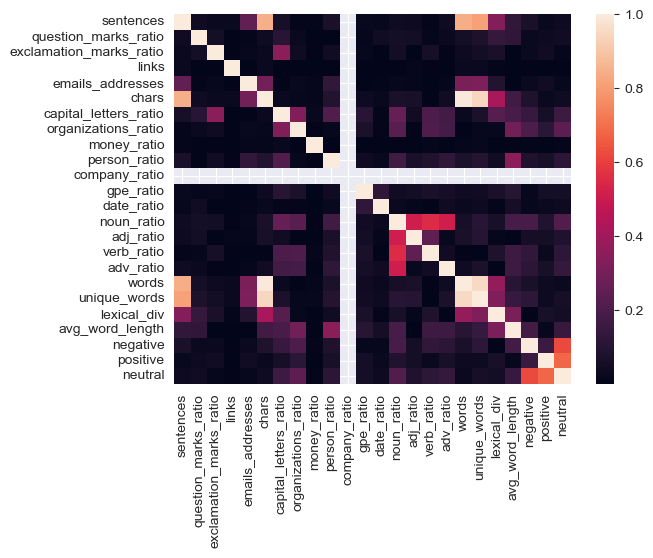

In [36]:
import numpy as np
import seaborn as sb

corr_matrix = df_numeric.corr(method="pearson").abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
dfplot = sb.heatmap(corr_matrix)

In [37]:
df_numeric = df_numeric.drop(to_drop, axis=1)
to_drop

['words', 'unique_words']

## Vectorizing

### CountVectorizer

In [38]:
import warnings
import re
from sklearn.feature_extraction.text import CountVectorizer

# Suppress the warning
warnings.filterwarnings("ignore", category=UserWarning)

count_vectorizer = CountVectorizer(stop_words = "english")
count_df = count_vectorizer.fit_transform(df["text"])
count_df

<13966x81723 sparse matrix of type '<class 'numpy.int64'>'
	with 1072791 stored elements in Compressed Sparse Row format>

### TfidfVectorizer

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features=7000)
tfidf_df = tfidf_vectorizer.fit_transform(df["text"])
tfidf_df

<13966x7000 sparse matrix of type '<class 'numpy.float64'>'
	with 876052 stored elements in Compressed Sparse Row format>

## Differences between vectorizers

In [40]:
count_df = pd.DataFrame(count_df.A, columns = count_vectorizer.get_feature_names_out())
tfidf_df = pd.DataFrame(tfidf_df.A, columns = tfidf_vectorizer.get_feature_names_out())
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

{'keating', 'anywaynot', 'warriner', 'stopping', 'offred', 'learned', 'zhigulis', 'israelizionist', 'azarbaijan', 'sciencerelated', 'upheld', 'inaugural', 'biggots', 'rost', 'kelder', 'tulhak', 'kl', 'readright', 'bohica', 'imputation', 'waythey', 'ansel', 'fdelete', 'unpatriotic', 'tancsa', 'coveted', 'fck', 'kur', 'arabisraeli', 'repaired', 'marr', 'rowdiness', 'tovmasian', 'enthusiasm', 'comoros', 'daybook', 'crimial', 'ln', 'nostalgia', 'satanists', 'outsider', 'asat', 'shellrootgeometrymanager', 'warped', 'tichauer', 'purposeyo', 'predestined', 'goosestepping', 'logistic', 'matrixvector', 'demytko', 'ratbastards', 'rift', 'usink', 'rizvi', 'survives', 'fluence', 'coffin', 'rationalist', 'turpin', 'americayesterdays', 'eckersley', 'willjail', 'vegr', 'tuan', 'doomed', 'redviolet', 'wmhintsflags', 'dovenistgov', 'predesigned', 'coaxial', 'mujahid', 'overlayplane', 'psychical', 'reposts', 'snappycomeback', 'lyonerstr', 'ifndef', 'ciphertextonly', 'canadaborn', 'pullman', 'turkskurds'

In [41]:
from scipy.sparse import hstack, csr_matrix

other_df = hstack([csr_matrix(df_numeric)])

In [42]:
other_df.shape

(13966, 22)

## Clustering scores

In [43]:
def print_scores(model, dataset, predictions, labels = df["newsgroup"]):
    print("Within-cluster sum of squares: %0.3f" % model.score(dataset))
    print("Silhouette Score: %0.3f" % silhouette_score(dataset, model.labels_, metric='euclidean'))
    print("Calinski Harabasz Score: %0.3f" % calinski_harabasz_score(dataset, model.labels_))
    print("Davies Bouldin: %0.3f" % davies_bouldin_score(dataset, predictions))
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, model.labels_))
    # print("Completeness: %0.3f" % metrics.completeness_score(labels, model.labels_))
    # print("V-measure: %0.3f" % metrics.v_measure_score(labels, model.labels_))
    # print("Adjusted Rand-Index: %.3f"
    #       % metrics.adjusted_rand_score(labels, model.labels_))
    # print("Silhouette Coefficient: %0.3f"
    #       % metrics.silhouette_score(tfidf_df, model.labels_, sample_size=1000))

## Most releveant terms

In [44]:
def print_most_relevant_terms(model, vectorizer,  n_of_clusters=20):
    centroids = model.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
    terms = vectorizer.get_feature_names_out()
    for i in range(n_of_clusters):
        print("Cluster %d:" % i, end='')
        for ind in centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()
    return centroids, terms

In [45]:
def plot_clusters(model, df, predictions):
    plt.figure(figsize=(8, 6))
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=predictions, cmap='viridis')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Clusters')
    plt.show()

## Clustering using k-means

In [46]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn import metrics
def kmeans(dataset):
    model = KMeans(n_clusters= 20, random_state = 101, n_init = 10)
    predictions = model.fit_predict(dataset)
    print_scores(model, dataset, predictions)
    return model

### tfidf_df

In [47]:
tfidf_km = kmeans(tfidf_df)

Within-cluster sum of squares: -13175.473
Silhouette Score: 0.009
Calinski Harabasz Score: 28.791
Davies Bouldin: 8.787
Homogeneity: 0.378


In [51]:
km_centroids, km_terms = print_most_relevant_terms(tfidf_km, tfidf_vectorizer)

Cluster 0: jew jewish muslim islam write arab article israel say people
Cluster 1: tax pay theory abortion insurance health evolution write coverage fact
Cluster 2: israel israeli arab palestinian kill lebanese peace gaza lebanon soldier
Cluster 3: key chip encryption clipper government use escrow phone algorithm nsa
Cluster 4: drive scsi disk ide hard controller floppy problem use mac
Cluster 5: space orbit shuttle launch moon detector mission satellite pat earth
Cluster 6: game espn baseball hockey play score playoff team night pitch
Cluster 7: god jesus christian believe bible say christ people sin faith
Cluster 8: card driver video ati diamond monitor mode color graphic use
Cluster 9: file format image program use window convert ftp directory gif
Cluster 10: window run program use windows application font problem manager nt
Cluster 11: write article say dont think know like make people bike
Cluster 12: objective value moral morality odwyer frank say science people article
Cluster 1

In [52]:
df['newsgroup']

12727          sci.electronics
12958          sci.electronics
17116    talk.politics.mideast
6186              misc.forsale
6782              misc.forsale
                 ...          
11051                sci.crypt
17409    talk.politics.mideast
8032           rec.motorcycles
13540                  sci.med
19755       talk.religion.misc
Name: newsgroup, Length: 13966, dtype: object

### other_df

In [53]:
other_km = kmeans(other_df.toarray())

Within-cluster sum of squares: -429.841
Silhouette Score: 0.086
Calinski Harabasz Score: 935.940
Davies Bouldin: 1.632
Homogeneity: 0.056


In [54]:
km_centroids_other, km_terms_other = print_most_relevant_terms(other_km, tfidf_vectorizer)

Cluster 0: absurd abraham abortion abroad absence absolutes abstract absolute ability absorb
Cluster 1: absurd abraham abroad absolutes absence abstract absorb absolute abide ability
Cluster 2: absurd abraham abroad ability abstract absence absolutes abide absorb absolute
Cluster 3: absurd abraham absolutes absence abroad abstract absolute abide ability absorb
Cluster 4: absurd abraham abroad absolutes absence absorb abstract absolute ability abide
Cluster 5: abraham absurd abstract abroad absence absolutes absolute abide absorb abolish
Cluster 6: absurd abraham abroad absolutes absence abstract absolute absorb abide ability
Cluster 7: absurd abide abraham absolutes absolutely aaa aaron abc aa ability
Cluster 8: absurd abraham abroad absolutes absence ability abstract abide absolute absorb
Cluster 9: absurd abraham absolutes abroad absence abide abolish ability abstract absolute
Cluster 10: absurd abraham abc abroad absolutes aa absence abstract ability absorb
Cluster 11: absurd abraha

We can see, that this doesn't work well

In [55]:
import pandas as pd

def count_rows_in_clusters(dataframe):
    # Filter out rows with NA values
    filtered_df = dataframe.dropna()

    # Count the number of rows in each cluster
    cluster_counts = filtered_df['cluster label'].value_counts()

    return cluster_counts

In [56]:
import numpy as np

def count_rows_in_clusters(cluster_labels):
    # Count the number of rows in each cluster
    cluster_counts = np.bincount(cluster_labels)

    return cluster_counts

Checking how many rows are in each cluster

In [57]:
count_rows_in_clusters(tfidf_km.labels_)

array([ 281,  217,  171,  379,  350,  494,  308,  707,  302,  366,  427,
       3433,  194,  132,  447,  764, 2313,  689,  879, 1113], dtype=int64)

### combined

In [58]:
labels1 = tfidf_km.predict(tfidf_df)
labels2 = other_km.predict(other_df)
combined_labels = np.column_stack((labels1, labels2))
combined_km = kmeans(combined_labels)

Within-cluster sum of squares: -31386.738
Silhouette Score: 0.467
Calinski Harabasz Score: 18244.188
Davies Bouldin: 0.754
Homogeneity: 0.144


## Word clouds

In [59]:
def frequencies_dict(cluster_index, model, centroids, terms):
    if cluster_index > 19:
        return
    term_frequencies = model.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def makeWordCloud(frequencies):

    wordcloud = WordCloud(width=800, height=400, max_font_size=100, background_color="white", max_words = 50)
    wordcloud.generate_from_frequencies(frequencies)

    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### tfidf_df

0


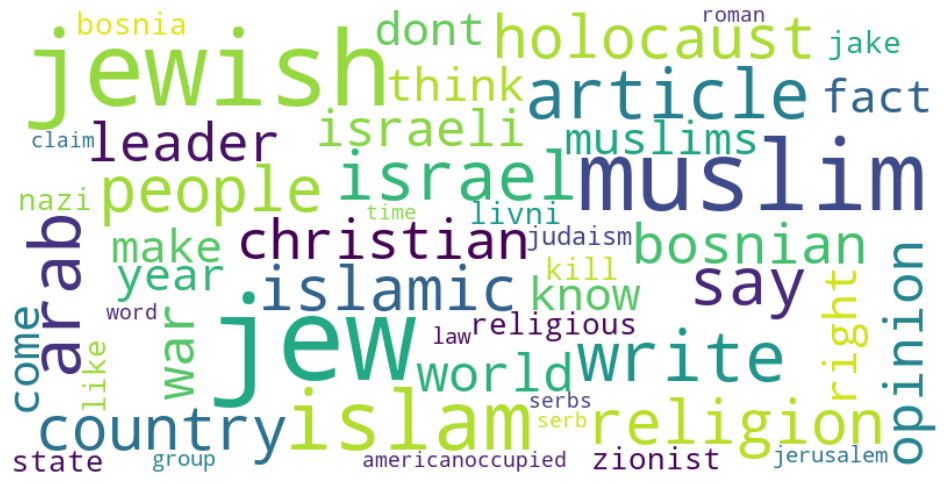

1


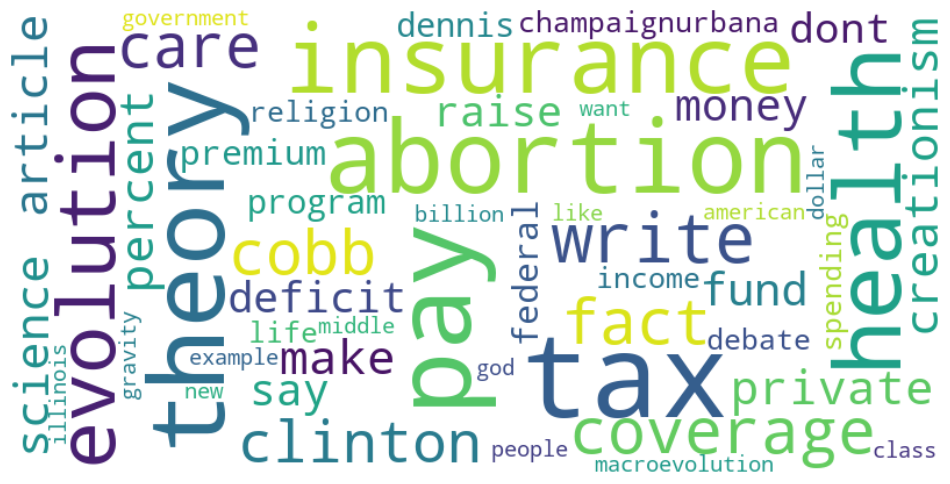

2


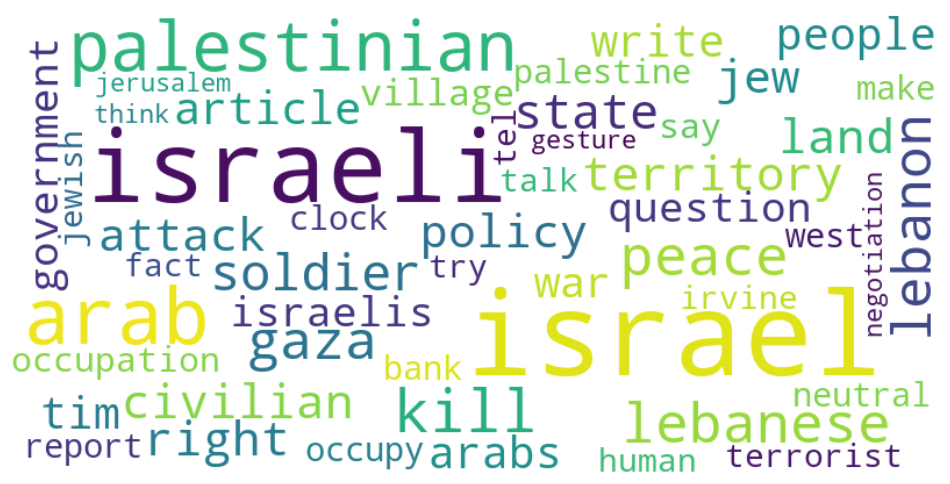

3


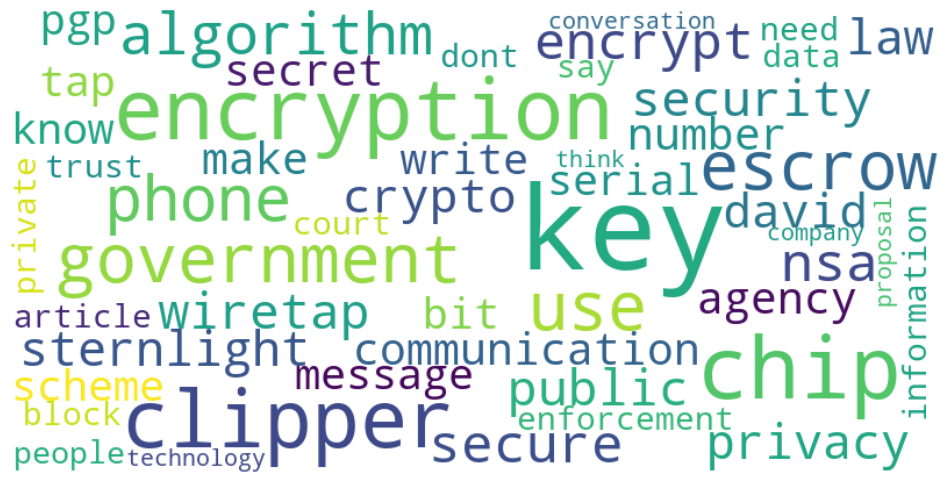

4


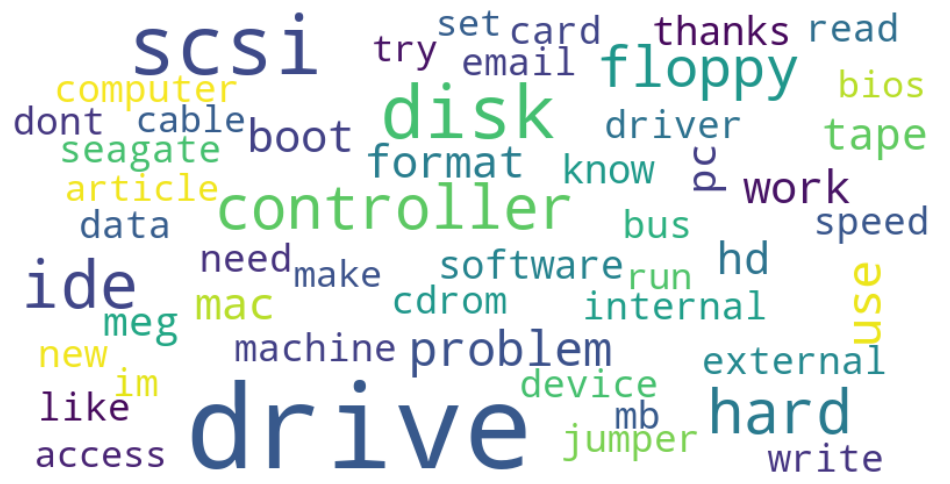

5


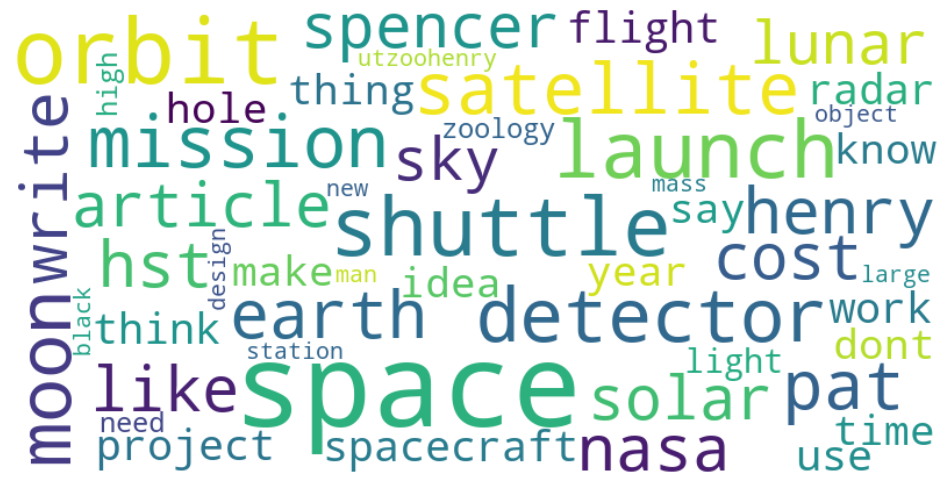

6


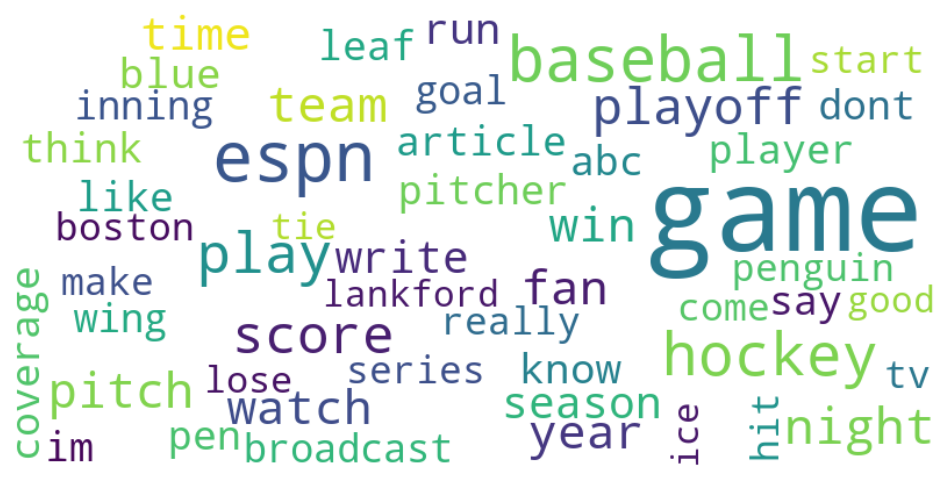

7


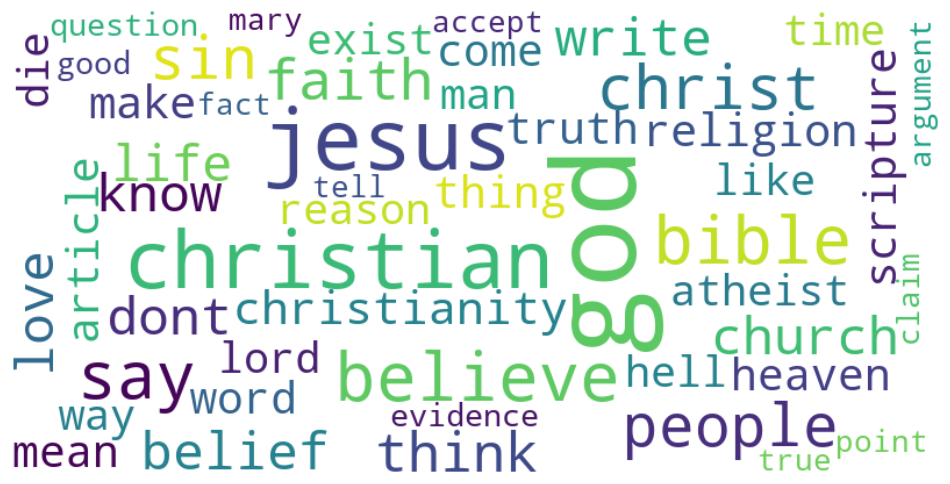

8


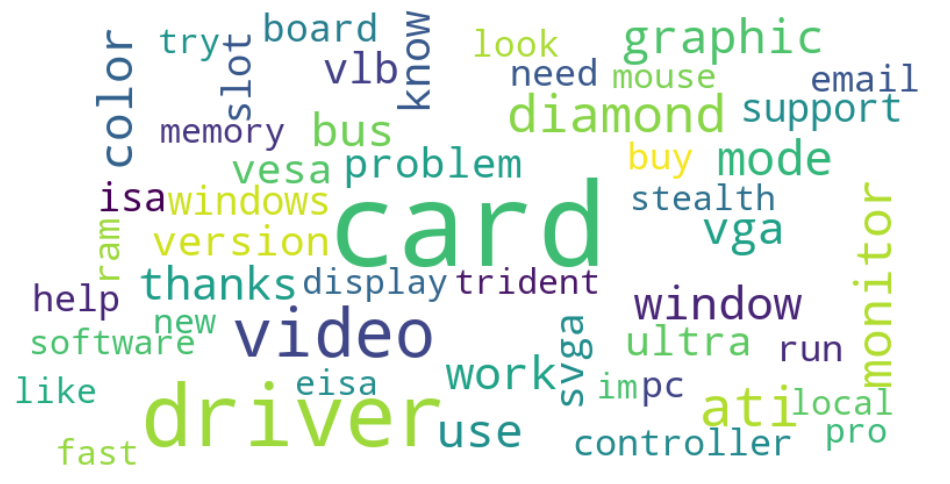

9


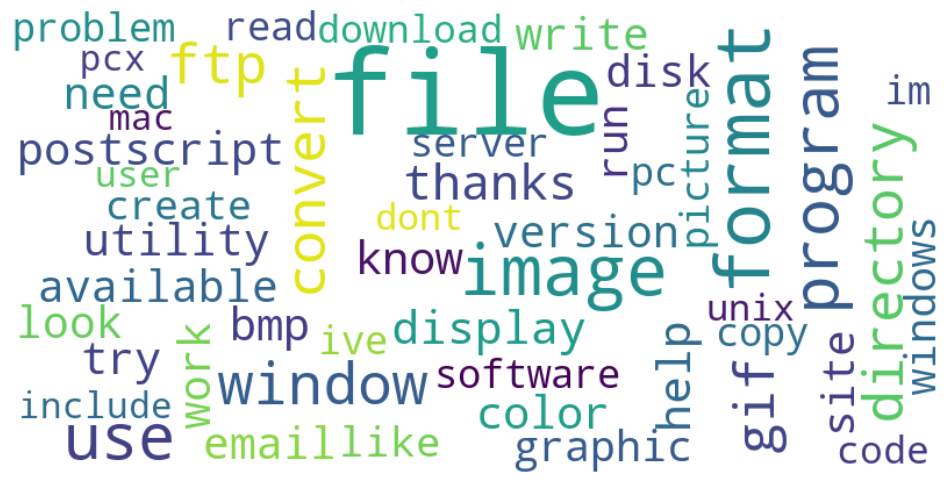

10


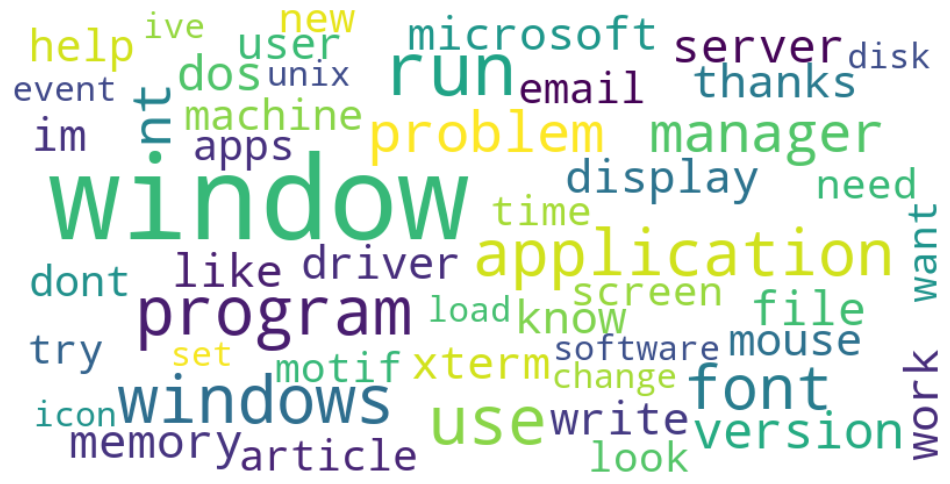

11


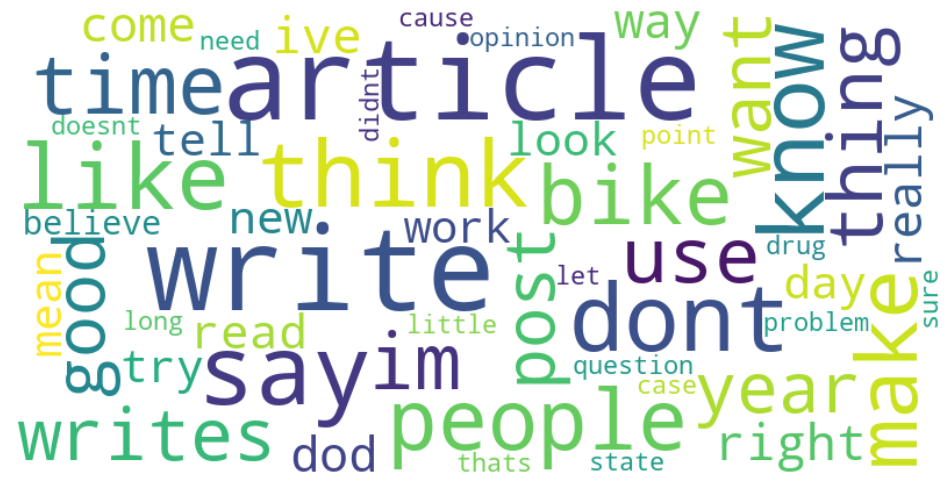

12


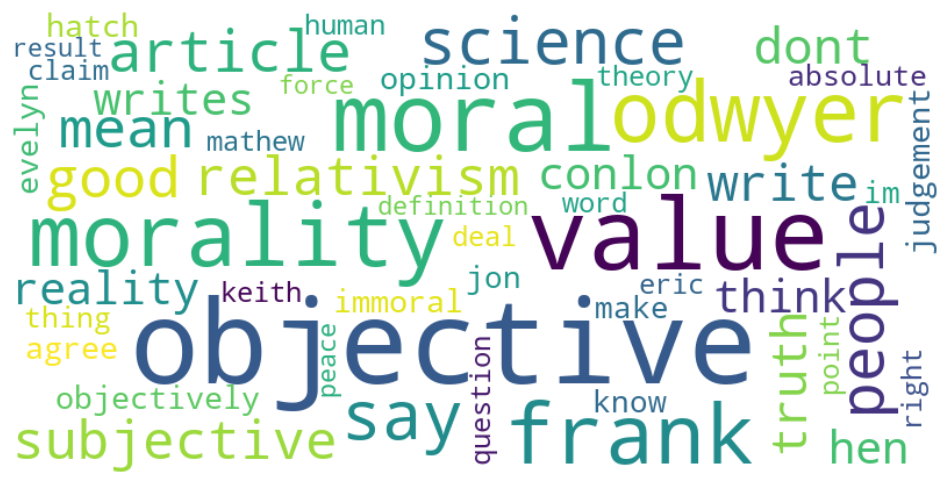

13


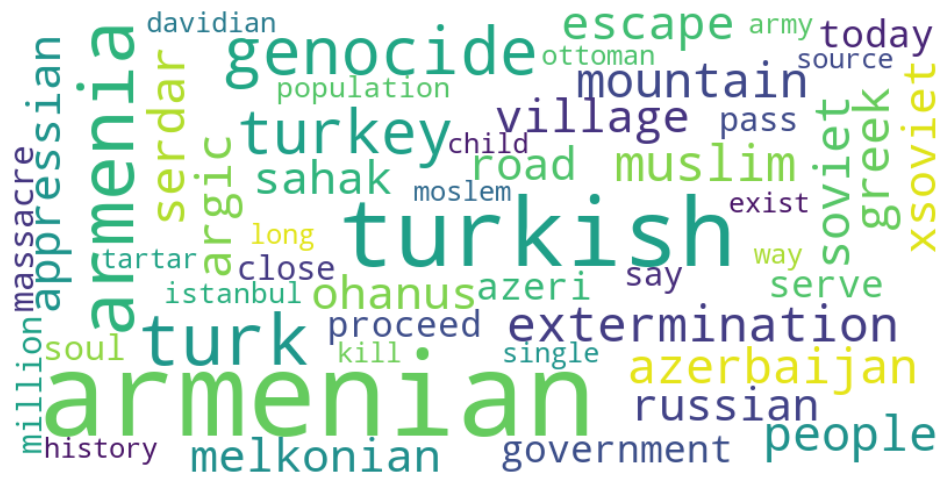

14


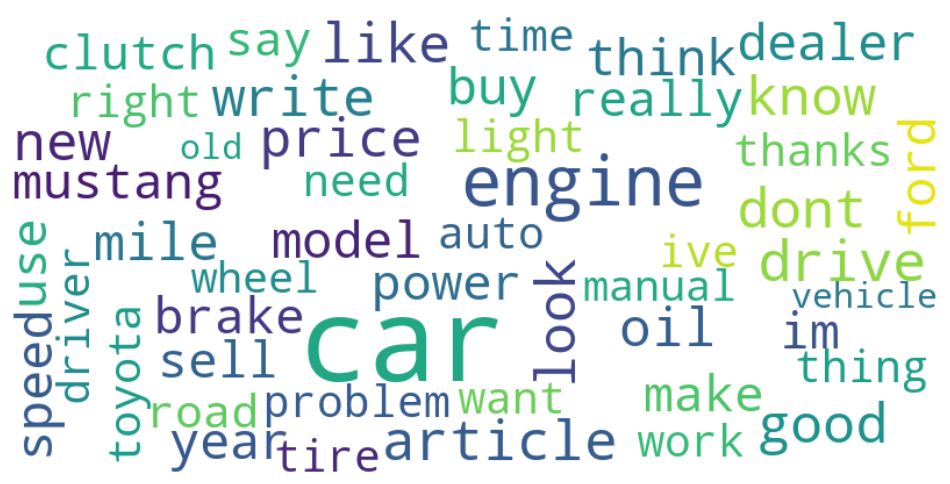

15


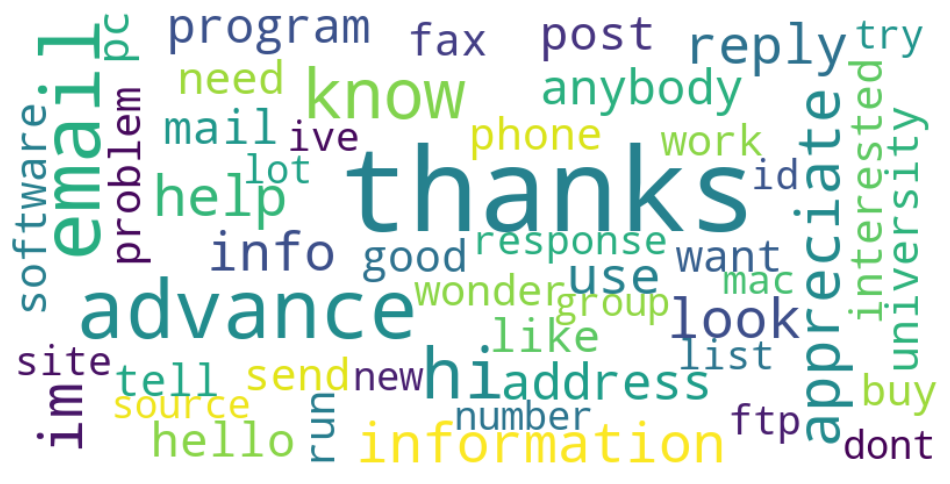

16


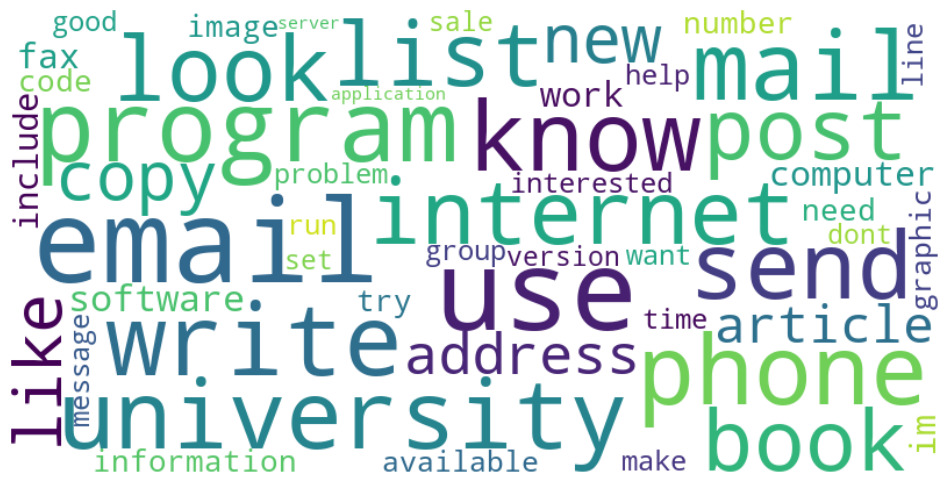

17


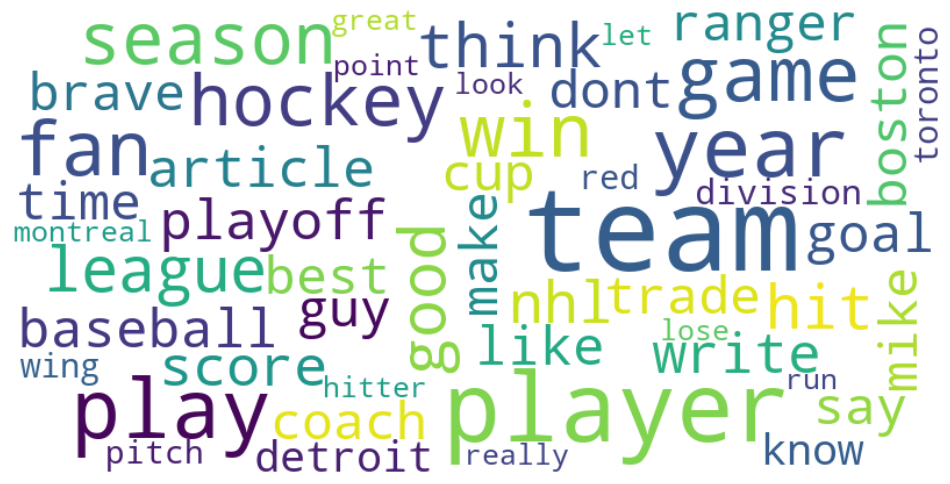

18


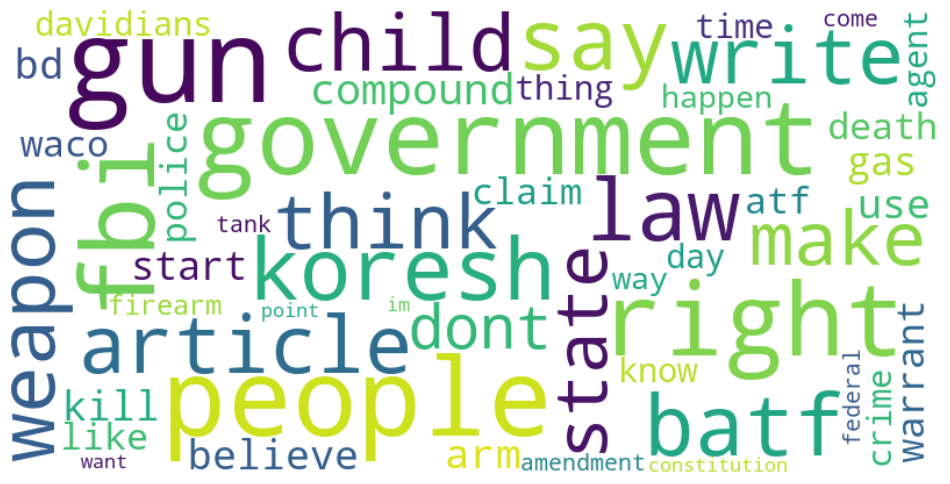

19


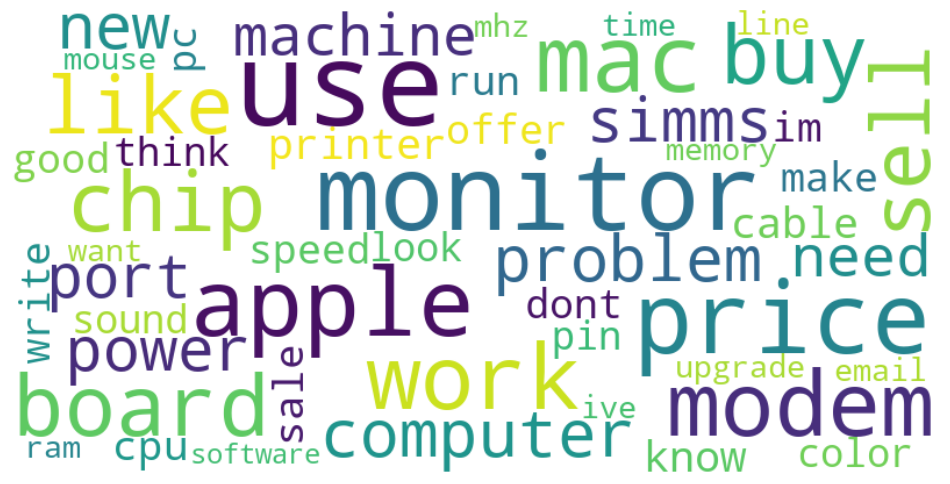

In [61]:
for i in range(20):
    freq = frequencies_dict(i, tfidf_km, km_centroids, km_terms)
    print(i)
    makeWordCloud(freq)

# AgglomerativeClustering

In [91]:
from sklearn.cluster import AgglomerativeClustering

def perform_agglomerative_clustering(vectorized_df, n_clusters=20):
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters)
    clustering_model.fit(vectorized_df)

    labels = clustering_model.labels_

    vectorized_df['Cluster'] = labels

    return vectorized_df

In [92]:
agg_model = perform_agglomerative_clustering(tfidf_df)

KeyboardInterrupt: 

In [65]:
print("Silhouette Score: %0.3f" % silhouette_score(tfidf_df, agg.labels_, metric='euclidean'))
print("Calinski Harabasz Score: %0.3f" % calinski_harabasz_score(tfidf_df, agg.labels_))
print("Davies Bouldin: %0.3f" % davies_bouldin_score(tfidf_df, add_pred))
labels = df["newsgroup"]
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, agg.labels_))

Silhouette Score: 0.002
Calinski Harabasz Score: 22.240
Davies Bouldin: 8.768
Homogeneity: 0.335


Results

In [89]:
def print_most_relevant_terms_agglo(model, vectorizer, data, n_of_clusters=20, top_n=10):
    labels = model.labels_
    terms = vectorizer.get_feature_names_out()
    unique_labels = set(labels)

    for cluster_label in unique_labels:
        cluster_indices = labels == cluster_label
        cluster_data = [data[i] for i, idx in enumerate(cluster_indices) if idx]

        if not cluster_data:
            continue  # Skip empty clusters

        cluster_vectorized_data = vectorizer.transform(cluster_data)
        cluster_term_scores = cluster_vectorized_data.sum(axis=0).A1
        top_term_indices = cluster_term_scores.argsort()[::-1][:top_n]
        top_terms = [terms[ind] for ind in top_term_indices]
        print(f"Cluster {cluster_label}: {' '.join(top_terms)}")

    return model, terms

In [90]:
model, terms = print_most_relevant_terms_agglo(agg, tfidf_vectorizer, tfidf_df)

KeyError: 33

In [ ]:
print_most_relevant_terms(agg, tfidf_vectorizer, tfidf_df, 7)

In [ ]:
terms = tfidf_vectorizer.get_feature_names_out()
predictions = agg.labels_
linkage_matrix = agg.children_
clusters_df = pd.DataFrame({'Text': tfidf_df, 'Cluster': predictions})

# Clustering for less number of clusters

## Clustering for n of subgroups (=7)

KMeans

In [66]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn import metrics
def kmeans(dataset, n_clusters = 20):
    model = KMeans(n_clusters, random_state = 101, n_init = 10)
    predictions = model.fit_predict(dataset)
    print_scores(model, dataset, predictions)
    return model

In [67]:
kmeans_7 = kmeans(tfidf_df, 7)

Within-cluster sum of squares: -13439.148
Silhouette Score: 0.005
Calinski Harabasz Score: 43.820
Davies Bouldin: 9.798
Homogeneity: 0.257


In [68]:
km_centroids_2, km_terms_2 = print_most_relevant_terms(kmeans_7, tfidf_vectorizer, 7)

Cluster 0: window file program use run thanks image windows display application
Cluster 1: people say article right write government dont think gun make
Cluster 2: game team player play year hockey win fan season baseball
Cluster 3: key chip encryption clipper government use escrow phone algorithm nsa
Cluster 4: god jesus christian believe say bible christ people sin think
Cluster 5: drive card monitor scsi disk driver use problem controller video
Cluster 6: write article know use like thanks im car dont email


# Visualization of clusters

In [69]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

def visualize_clusters(dataset, predictions):
    svd = TruncatedSVD(n_components=2, random_state=101)
    reduced_features = svd.fit_transform(dataset)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=predictions, cmap='viridis')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('Cluster Visualization')
    plt.colorbar(label='Cluster')
    plt.show()


### KMeans

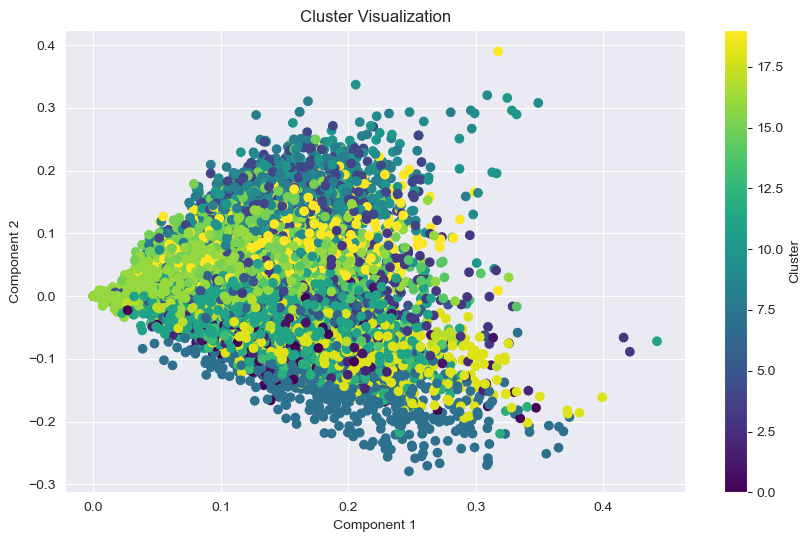

In [70]:
km_predictions = tfidf_km.fit_predict(tfidf_df)
visualize_clusters(tfidf_df, km_predictions)

In [71]:
from scipy.spatial.distance import pdist, squareform

def create_distance_matrix(dataset):
    # Compute pairwise distances between data points using Euclidean distance
    distance_matrix = pdist(dataset, metric='euclidean')

    # Convert the pairwise distances to a square distance matrix
    distance_matrix = squareform(distance_matrix)

    return distance_matrix


In [ ]:
dist_matrix_km = create_distance_matrix(tfidf_df)

In [72]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def create_distance_matrix(dataset, subset_size=1000):
    # Randomly select a subset of data points
    indices = np.random.choice(dataset.shape[0], size=subset_size, replace=False)
    subset = dataset.iloc[indices, :]

    # Compute pairwise distances between subset data points using Euclidean distance
    distance_matrix = pdist(subset.values, metric='euclidean')

    # Convert the pairwise distances to a square distance matrix
    distance_matrix = squareform(distance_matrix)

    return distance_matrix


In [73]:

distance_matrix = create_distance_matrix(tfidf_df, subset_size=5000)

In [74]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

def draw_dendrogram(distance_matrix):
    # Perform hierarchical clustering using the distance matrix
    linkage_matrix = linkage(distance_matrix, method='ward')

    # Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix)
    plt.xlabel('Data Points')
    plt.ylabel('Distance')
    plt.title('Dendrogram')
    plt.show()


propably dumb since we have over 13.000 records

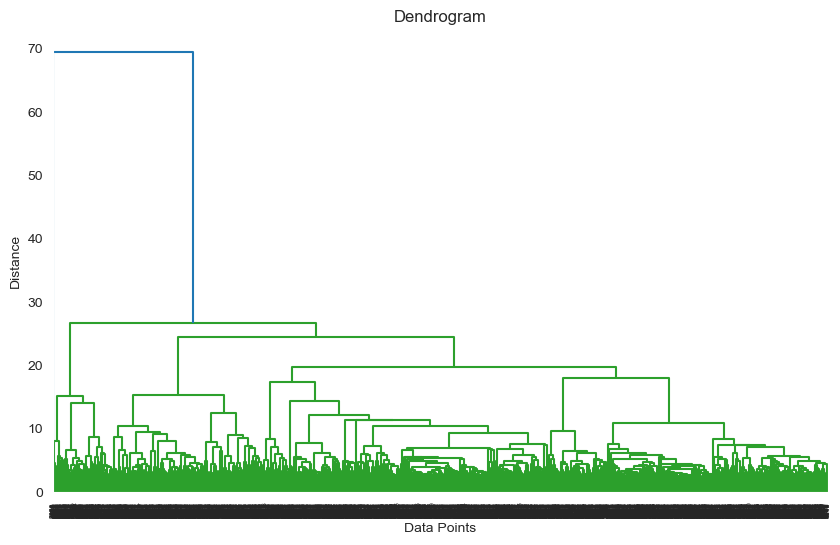

In [75]:

draw_dendrogram(distance_matrix)

# Confusion matrix

In [93]:
data_means_20 = df
labels_kmeans = tfidf_km.labels_
data_means_20['Cluster'] = labels_kmeans
data_means_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13966 entries, 12727 to 19755
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   text                     13966 non-null  object 
 1   newsgroup                13966 non-null  object 
 2   sentences                13966 non-null  int64  
 3   question_marks_ratio     13966 non-null  float64
 4   exclamation_marks_ratio  13966 non-null  float64
 5   links                    13966 non-null  int64  
 6   emails_addresses         13966 non-null  int64  
 7   chars                    13966 non-null  int64  
 8   capital_letters_ratio    13966 non-null  float64
 9   organizations_ratio      13966 non-null  float64
 10  money_ratio              13966 non-null  float64
 11  person_ratio             13966 non-null  float64
 12  company_ratio            13966 non-null  float64
 13  gpe_ratio                13966 non-null  float64
 14  date_ratio        

C:\Users\User\AppData\Local\Temp\ipykernel_10276\3953939782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_means_20['Cluster'] = labels_kmeans


In [94]:
data_means_20

text  \
12727  article pethybridge write hello ask year ago s...   
12958  scielectronics geoff swan writes rubbish reaso...   
17116  article craig brown writes article mohamad ebr...   
6186   gre test aid sale cliff gre preparation guide ...   
6782    size wed dress lot bead inquire mst utah pay ask   
...                                                  ...   
11051  yes error need diff standard consoleh consolec...   
17409  article casperdavippe write aware arm embargo ...   
8032   first start rid street bike tell common reciev...   
13540  hi complete project nebuliser performance weal...   
19755  article write actually positive argument posit...   

                   newsgroup  sentences  question_marks_ratio  \
12727        sci.electronics          4              0.000000   
12958        sci.electronics         17              0.117647   
17116  talk.politics.mideast         25              0.040000   
6186            misc.forsale         18              0.000000   
6782            misc.forsale          2              0.000000   
...                      ...        ...                   ...   
11051              sci.crypt          4              0.250000   
17409  talk.politics.mideast         13              0.230769   
8032         rec.motorcycles          8              0.000000   
13540                sci.med          6              0.166667   
19755     talk.religion.misc         22              0.045455   

       exclamation_marks_ratio  links  emails_addresses  chars  \
12727                 0.000000      0                 2    412   
12958                 0.000000      0                 4   2285   
17116                 0.280000      0                 4   3761   
6186                  0.333333      0                 1    911   
6782                  0.000000      0                 0     75   
...                        ...    ...               ...    ...   
11051                 0.000000      0                 1    407   
17409                 0.153846      0                 3   1252   
8032                  0.250000      0                 1    498   
13540                 0.000000      0                 1    857   
19755                 0.000000      0                 2   1692   

       capital_letters_ratio  organizations_ratio  ...  verb_ratio  adv_ratio  \
12727               0.054054             0.000000  ...    0.238095   0.119048   
12958               0.074132             0.011816  ...    0.244186   0.073643   
17116               0.031100             0.005584  ...    0.184659   0.042614   
6186                0.109948             0.036224  ...    0.205882   0.019608   
6782                0.150000             0.013333  ...    0.500000   0.000000   
...                      ...                  ...  ...         ...        ...   
11051               0.134328             0.027027  ...    0.250000   0.045455   
17409               0.055233             0.002396  ...    0.269565   0.086957   
8032                0.056931             0.010040  ...    0.235294   0.078431   
13540               0.049793             0.000000  ...    0.148148   0.012346   
19755               0.022727             0.006501  ...    0.208861   0.050633   

       words  unique_words  lexical_div  avg_word_length  negative  positive  \
12727     42            36     1.166667         9.809524     0.173     0.064   
12958    258           179     1.441341         8.856589     0.068     0.057   
17116    352           256     1.375000        10.684659     0.087     0.208   
6186     102            68     1.500000         8.931373     0.081     0.091   
6782      10            10     1.000000         7.500000     0.135     0.000   
...      ...           ...          ...              ...       ...       ...   
11051     44            42     1.047619         9.250000     0.094     0.143   
17409    115            92     1.250000        10.886957     0.183     0.137   
8032      51            46     1.108696         9.764706     0.0

In [95]:
import pandas as pd

def calculate_cluster_ratio(df):
    # Group the data frame by 'newsgroup' and 'cluster'
    grouped_df = df.groupby(['newsgroup', 'Cluster']).size().reset_index(name='count')

    # Calculate the total count for each cluster
    total_counts = grouped_df.groupby('Cluster')['count'].transform('sum')

    # Calculate the ratio for each newsgroup within each cluster
    grouped_df['ratio'] = grouped_df['count'] / total_counts * 100

    return grouped_df

In [96]:
df_matrix = calculate_cluster_ratio(data_means_20)

In [97]:
df_matrix

newsgroup  Cluster  count      ratio
0           alt.atheism        0     37  13.167260
1           alt.atheism        1     34  15.668203
2           alt.atheism        3      1   0.263852
3           alt.atheism        5     14   2.834008
4           alt.atheism        7    158  22.347949
..                  ...      ...    ...        ...
216  talk.religion.misc       14      5   1.118568
217  talk.religion.misc       15      3   0.392670
218  talk.religion.misc       16     40   1.729356
219  talk.religion.misc       17      1   0.145138
220  talk.religion.misc       18    113  12.855518

[221 rows x 4 columns]

In [100]:
import pandas as pd
import itertools

def calculate_cluster_ratio(df):
    # Get all unique combinations of 'newsgroup' and 'cluster'
    unique_combinations = pd.DataFrame(list(itertools.product(df['newsgroup'].unique(), df['Cluster'].unique())), columns=['newsgroup', 'Cluster'])

    # Group the data frame by 'newsgroup' and 'cluster'
    grouped_df = df.groupby(['newsgroup', 'Cluster']).size().reset_index(name='count')

    # Calculate the total count for each cluster
    total_counts = grouped_df.groupby('Cluster')['count'].transform('sum')

    # Calculate the ratio for each newsgroup within each cluster
    grouped_df['ratio'] = grouped_df['count'] / total_counts * 100

    # Merge with unique combinations to include all combinations
    result_df = unique_combinations.merge(grouped_df, on=['newsgroup', 'Cluster'], how='left')

    # Fill NaN values in ratio with 0
    result_df['ratio'].fillna(0, inplace=True)

    return result_df


In [101]:
df_i = calculate_cluster_ratio(data_means_20)

In [102]:
df_i

newsgroup  Cluster  count      ratio
0    sci.electronics       19  212.0  19.047619
1    sci.electronics       11  107.0   3.116807
2    sci.electronics       16  212.0   9.165586
3    sci.electronics       17    NaN   0.000000
4    sci.electronics       10    2.0   0.468384
..               ...      ...    ...        ...
395        rec.autos        0    NaN   0.000000
396        rec.autos       14  364.0  81.431767
397        rec.autos        9    NaN   0.000000
398        rec.autos       12    NaN   0.000000
399        rec.autos        4    4.0   1.142857

[400 rows x 4 columns]

In [117]:
import seaborn as sns

def draw_ratio_heatmap(data_frame):
    # Pivot the data frame to get the required format for heatmap
    heatmap_data = data_frame.pivot(index='Cluster', columns='newsgroup', values='ratio')

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='viridis', cbar=True, ax=ax)

    # Set the title and axis labels
    ax.set_title('Ratio Heatmap')
    ax.set_xlabel('Newsgroups')
    ax.set_ylabel('Clusters')

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=90)

    # Show the plot
    plt.tight_layout()
    plt.show()



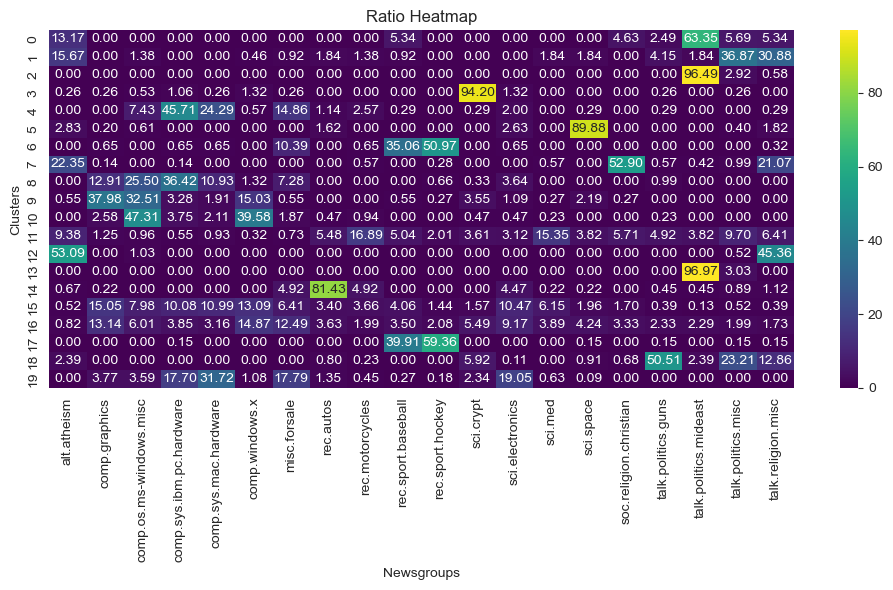

In [118]:
draw_ratio_heatmap(df_i)